In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Lambda, Layer, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import mean_squared_error, binary_crossentropy, kullback_leibler_divergence
from tensorflow.keras.callbacks import EarlyStopping, TerminateOnNaN, ReduceLROnPlateau
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, scipy
from sklearn.model_selection import train_test_split

from phenom_read_in_data import *
from fpr_tpr_calc import *

In [31]:
path1 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan3/signals/glgl1400_neutralino1100_chan3.csv'
path2 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan3/signals/glgl1600_neutralino800_chan3.csv'
path3 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan3/signals/gluino_1000.0_neutralino_1.0_chan3_200000.csv'
path4 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan3/signals/monoV_Zp2000.0_DM_1.0_chan3.csv'
path5 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan3/signals/monojet_Zp2000.0_DM_50.0_chan3.csv'
path6 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan3/signals/monotop_200_A_chan3.csv'
path7 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan3/signals/sqsq1_sq1400_neut800_chan3.csv'
path8 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan3/signals/sqsq_sq1800_neut800_chan3.csv'
path9 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan3/signals/stlp_st1000_chan3.csv'
path10 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan3/signals/stop2b1000_neutralino300_chan3.csv'

In [32]:
paths = [path1, path2, path3, path4, path5, path6, path7, path8, path9, path10]

In [33]:
#Getthe data
df_bkg = single_csv_to_df('/home/joe/Documents/Work/PhD/dark_machines/training_files/chan3/background_chan3_8.02_200000.csv')

In [34]:
for path in paths:
    temp = single_csv_to_df(path)
    if (len(temp.columns) > len(df_bkg.columns)):
        diff = int(((len(temp.columns)-5)/5))-int(((len(df_bkg.columns)-5)/5))
        num = int(((len(df_bkg.columns) - 5)/5) + 1)
        for i in range(diff):
            df_bkg['obj'+str(num)]= -999
            df_bkg['E'+str(num)] = -999
            df_bkg['pt'+str(num)] = -999
            df_bkg['eta'+str(num)] = -999
            df_bkg['phi'+str(num)] = -999
            num+=1

In [35]:
df_bkg

,event_ID,process_ID,event_weight,MET,MET_Phi,obj1,E1,pt1,eta1,phi1,...,obj18,E18,pt18,eta18,phi18,obj19,E19,pt19,eta19,phi19
0,16941885,njets,1,100881,2.25584,j,905538,466807,-1.28025,-0.97045,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,159940776,njets,1,144050,-0.412954,b,470651,358331,-0.770564,-0.35984,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,168908747,njets,1,104442,0.180383,j,288901,268383,0.354942,0.304771,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,144004174,njets,1,193479,-0.0460751,j,881925,471724,-1.23801,3.08542,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,55406310,njets,1,139352,-1.5856,j,619966,406938,-0.981054,1.61988,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,164475365,njets,1,143422,-0.30802,j,809590,409811,1.30099,-3.00886,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
199996,77476112,njets,1,103228,0.997506,j,501438,402542,-0.681099,-2.02738,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
199997,56243201,njets,1,110893,1.70124,j,358506,317238,-0.493772,1.40277,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
199998,2149006,njets,1,156856,2.50748,j,371246,370114,-0.0171899,2.67509,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


In [36]:
#If the number of max objects is prime, another column needs to be added to mitigate 

In [37]:
if ((len(df_bkg.columns)-5) % 2 != 0):
    num = str(int(((len(df_bkg.columns) - 5)/5) + 1))
    df_bkg['obj'+num]= -999
    df_bkg['E'+num] = -999
    df_bkg['pt'+num] = -999
    df_bkg['eta'+num] = -999
    df_bkg['phi'+num] = -999

In [38]:
df_bkg

,event_ID,process_ID,event_weight,MET,MET_Phi,obj1,E1,pt1,eta1,phi1,...,obj19,E19,pt19,eta19,phi19,obj20,E20,pt20,eta20,phi20
0,16941885,njets,1,100881,2.25584,j,905538,466807,-1.28025,-0.97045,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,159940776,njets,1,144050,-0.412954,b,470651,358331,-0.770564,-0.35984,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,168908747,njets,1,104442,0.180383,j,288901,268383,0.354942,0.304771,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,144004174,njets,1,193479,-0.0460751,j,881925,471724,-1.23801,3.08542,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,55406310,njets,1,139352,-1.5856,j,619966,406938,-0.981054,1.61988,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,164475365,njets,1,143422,-0.30802,j,809590,409811,1.30099,-3.00886,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
199996,77476112,njets,1,103228,0.997506,j,501438,402542,-0.681099,-2.02738,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
199997,56243201,njets,1,110893,1.70124,j,358506,317238,-0.493772,1.40277,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
199998,2149006,njets,1,156856,2.50748,j,371246,370114,-0.0171899,2.67509,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


In [39]:
df = df_bkg.fillna(-999)
variables = [entry for entry in df.columns if entry[0] == 'E'] + [entry for entry in df.columns if entry[0:2] == 'pt'] + [entry for entry in df.columns if entry[0:2] == 'et'] + [entry for entry in df.columns if entry[0:2] == 'ph']

In [40]:
#Now we one_hot encode the data to make sure we have a class definition
df = df[['process_ID']+variables]
one_hot = pd.get_dummies(df['process_ID'])
processes = one_hot.columns
df.drop('process_ID', axis = 'columns', inplace = True)
df = pd.concat([df, one_hot], sort = False, axis = 1)

In [41]:
E = [entry for entry in df.columns if entry[0] == 'E']
pt = [entry for entry in df.columns if entry[0:2] == 'pt']
eta = [entry for entry in df.columns if entry[0:2] == 'et']
phi = [entry for entry in df.columns if entry[0:2] == 'ph']

In [42]:
np_E = np.array(df[E])
np_pt = np.array(df[pt])
np_eta = np.array(df[eta])
np_phi = np.array(df[phi])

In [43]:
#We have created a df of our values and some kind of class label
#We should normalize
x = df[variables].values
x_scaled = StandardScaler().fit_transform(x)
df[variables] = x_scaled

x_train, x_test, y_train, y_test = train_test_split(df[variables].values,
                                                    df[processes].values, 
                                                    shuffle = True,
                                                    random_state = 42,
                                                    test_size = 0.1)

In [44]:
#Reshape the data. This will have to be done explicitly until you think of a clever way of doing it
x_train = x_train.reshape((x_train.shape[0], 1, -1, 4))
x_test = x_test.reshape((x_test.shape[0], 1, -1, 4))

In [45]:
#VAE Model
original_dim = x_train.shape[0]
input_shape = x_train.shape[1:]
latent_dim = 4
intermediate_dim = 50
kernel_max_norm = 1000.
act_fun = 'relu'
epsilon_std = 1.
filters = 32
kernel_size = (2, 2)
strides = (1, 1)
pool_size = (1, 1)

In [46]:
K.clear_session()

In [47]:
def sampling(args):
    z_mean, z_log_var=args
    epsilon=tf.random.uniform(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean+K.exp(z_log_var/2)*epsilon
    
#Define some losses
def kl_loss(y_true, y_pred):
    kl_loss = 1 + z_var - K.square(z_mean) - K.exp(z_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    #kl_loss = K.mean(kl_loss)
    return kl_loss

def recon_loss(y_true, y_pred):
    recon_loss = mean_squared_error(K.flatten(y_true), K.flatten(y_pred))
    recon_loss *= shape[0]*shape[1]*shape[2]
    #recon_loss = K.mean(recon_loss)
    return recon_loss
    
def my_vae_loss(y_true, y_pred):
    recon = recon_loss(y_true, y_pred) 
    kl = kl_loss(y_true, y_pred)
    vae_loss = recon + kl
    return vae_loss

    
    #Layers
x_input = Input(shape = input_shape, name = 'Input')
conv_1 = Conv2D(filters = filters, 
                activation = act_fun,
                kernel_size = kernel_size,
                strides = strides, 
                padding = 'same', 
                name = 'conv_1')(x_input)
pool_1 = MaxPooling2D(pool_size = pool_size,
                          strides = 2, 
                          name = 'max_pool')(conv_1)
conv_2 = Conv2D(filters = filters, 
                activation = act_fun, 
                kernel_size = kernel_size, 
                strides = strides, 
                padding = 'same', 
                name = 'conv_2')(pool_1)
#Shape info needed to inform the dense layer in the decoder
flatten = Flatten()(conv_2)#(pool_1)
cnn = Model(x_input, flatten, name = 'cnn')
cnn.summary()

shape = input_shape
    
#Encoding
dense_encoder_1 = Dense(intermediate_dim,
                            activation = act_fun,
                            name = 'dense_encoder_1')(flatten)
dense_encoder_2 = Dense(16,
                            activation = act_fun,
                            name = 'dense_encoder_2')(dense_encoder_1)
z_mean = Dense(latent_dim, name = 'z_mean')(dense_encoder_2)
z_var = Dense(latent_dim, name = 'z_var')(dense_encoder_2)

z = Lambda(sampling, output_shape = (latent_dim, ), name = 'sampling')([z_mean, z_var])

encoder = Model(x_input, [z_mean, z_var, z], name = 'encoder')
encoder.summary()
    
#Decoding
dense_shape = shape[0]*shape[1]*shape[2]
decoder_input = Input(shape = (latent_dim, ), name = 'decoder_input')
dense_decoder_1 = Dense(dense_shape, 
                            activation = act_fun, 
                            name = 'dense_decoder_1')(decoder_input)
reshape = Reshape((shape[0], shape[1], shape[2]))(dense_decoder_1)

deconv_1 = Conv2DTranspose(filters = filters,
                               kernel_size = kernel_size, 
                               activation = act_fun, 
                               strides = strides, 
                               padding = 'same', 
                               name = 'deconv_1')(reshape)
deconv_2 = Conv2DTranspose(filters = 20,
                               kernel_size = kernel_size, 
                               activation = act_fun, 
                               strides = strides, 
                               padding = 'same', 
                               name = 'deconv_2')(deconv_1)

output = Conv2DTranspose(filters = 4, 
                             kernel_size = kernel_size, 
                             #activation = 'sigmoid', 
                             padding = 'same', 
                             strides = strides, 
                             name = 'decoder_output')(deconv_2)

decoder = Model(decoder_input, output, name = 'decoder')
decoder.summary()
    
#Build the VAE model
#outputs = decoder(encoder(x_input)[2])
#vae = Model(x_input, outputs, name = 'vae')
    
#vae.compile(optimizer = 'rmsprop', loss = my_vae_loss, metrics = [kl_loss, recon_loss])
#vae.summary()

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 1, 20, 4)]        0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 1, 20, 32)         544       
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 1, 10, 32)         0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 1, 10, 32)         4128      
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
Total params: 4,672
Trainable params: 4,672
Non-trainable params: 0
_________________________________________________________________
Model: "encoder"
__________________________________________________________________________________________________
Layer (type

In [48]:
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape =(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mse(data, reconstruction)
            )
            reconstruction_loss *= 14*4
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    
    #def call(self, inputs, **kwargs):
    #    return self.model(inputs, decoder)

In [49]:
#Build the VAE model
#outputs = decoder(encoder(x_input)[2])
vae = VAE(encoder, decoder)
vae.compile(optimizer = 'rmsprop')#, loss = my_vae_loss, metrics = [kl_loss, recon_loss])

In [50]:
x_val = x_train[:int(len(x_train)/3.)]
x_train = x_train[int(len(x_train)/3.):]

In [51]:
#Fit the model
epochs = 100
batch_size = 1000
history_val = vae.fit(x = x_val, epochs = epochs, batch_size = batch_size, verbose = 0)

history_train = vae.fit(x = x_train, epochs = epochs, batch_size = batch_size, verbose = 2)

Epoch 1/100
120/120 - 6s - loss: 5.9816 - reconstruction_loss: 5.1576 - kl_loss: 0.8239
Epoch 2/100
120/120 - 6s - loss: 6.8387 - reconstruction_loss: 5.9376 - kl_loss: 0.9011
Epoch 3/100
120/120 - 6s - loss: 5.8181 - reconstruction_loss: 5.0646 - kl_loss: 0.7535
Epoch 4/100
120/120 - 6s - loss: 5.8162 - reconstruction_loss: 5.0628 - kl_loss: 0.7533
Epoch 5/100
120/120 - 6s - loss: 6.3038 - reconstruction_loss: 5.4748 - kl_loss: 0.8290
Epoch 6/100
120/120 - 6s - loss: 6.5532 - reconstruction_loss: 5.6633 - kl_loss: 0.8899
Epoch 7/100
120/120 - 6s - loss: 5.8005 - reconstruction_loss: 5.0419 - kl_loss: 0.7586
Epoch 8/100
120/120 - 6s - loss: 5.6402 - reconstruction_loss: 4.8757 - kl_loss: 0.7645
Epoch 9/100
120/120 - 6s - loss: 6.3233 - reconstruction_loss: 5.5111 - kl_loss: 0.8122
Epoch 10/100
120/120 - 7s - loss: 6.7429 - reconstruction_loss: 5.8314 - kl_loss: 0.9115
Epoch 11/100
120/120 - 7s - loss: 5.6594 - reconstruction_loss: 4.8906 - kl_loss: 0.7688
Epoch 12/100
120/120 - 6s - lo

120/120 - 6s - loss: 5.2851 - reconstruction_loss: 4.4756 - kl_loss: 0.8094
Epoch 94/100
120/120 - 6s - loss: 4.8874 - reconstruction_loss: 4.1233 - kl_loss: 0.7641
Epoch 95/100
120/120 - 6s - loss: 5.2953 - reconstruction_loss: 4.5192 - kl_loss: 0.7762
Epoch 96/100
120/120 - 6s - loss: 5.3003 - reconstruction_loss: 4.5311 - kl_loss: 0.7692
Epoch 97/100
120/120 - 6s - loss: 15.0191 - reconstruction_loss: 12.7186 - kl_loss: 2.3005
Epoch 98/100
120/120 - 6s - loss: 6.1498 - reconstruction_loss: 5.2488 - kl_loss: 0.9009
Epoch 99/100
120/120 - 6s - loss: 17.8694 - reconstruction_loss: 16.2279 - kl_loss: 1.6415
Epoch 100/100
120/120 - 6s - loss: 5.2405 - reconstruction_loss: 4.4255 - kl_loss: 0.8151


In [52]:
_, _, z = encoder.predict(x_test.reshape(x_test.shape[0], 1, -1, 4))
y_pred = decoder.predict(z)

In [53]:
x_test_reshape = x_test.reshape(x_test.shape[0], -1)

In [54]:
x_test_df = pd.DataFrame(x_test_reshape, columns = variables)

In [55]:
x_test_E = np.array(x_test_df[E])
x_test_pt = np.array(x_test_df[pt])
x_test_phi = np.array(x_test_df[phi])
x_test_eta = np.array(x_test_df[eta])

In [56]:
y_pred_reshape = y_pred.reshape(y_pred.shape[0], -1)

In [57]:
y_pred_df = pd.DataFrame(y_pred_reshape, columns = variables)

In [58]:
y_pred_E = np.array(y_pred_df[E])
y_pred_pt = np.array(y_pred_df[pt])
y_pred_phi = np.array(y_pred_df[phi])
y_pred_eta = np.array(y_pred_df[eta])

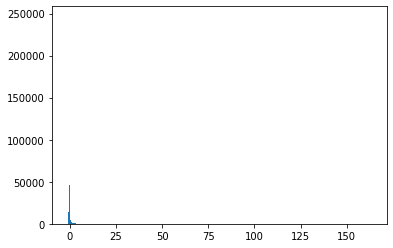

In [59]:
n, bins, patches = plt.hist(x_test_E.flatten(), 1000)

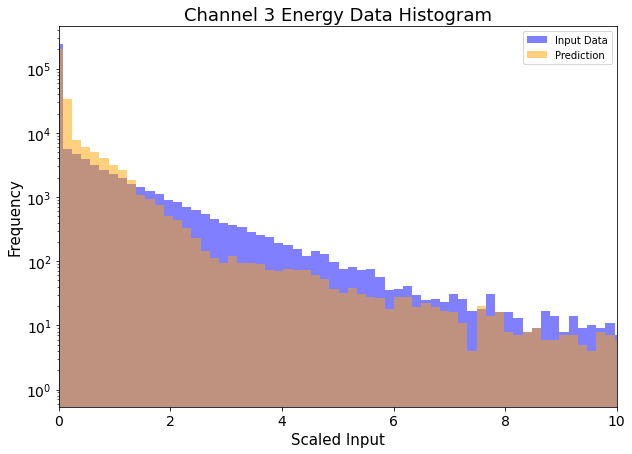

In [60]:
plt.figure(figsize=(10,7))
plt.xlim(0, 10)
plt.xlabel('Scaled Input', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Frequency', fontsize = 15)
plt.title('Channel 3 Energy Data Histogram', fontsize = 18)
plt.hist(x_test_E.flatten(), bins = bins, color='blue', log=True, label='Input Data', alpha=0.5)
plt.hist(y_pred_E.flatten(), bins = bins, color='orange', log=True, label='Prediction', alpha=0.5)
plt.legend()
plt.show()

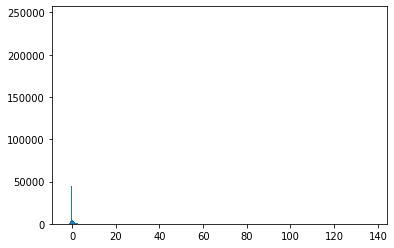

In [61]:
n, bins, patches = plt.hist(x_test_pt.flatten(), 1000)

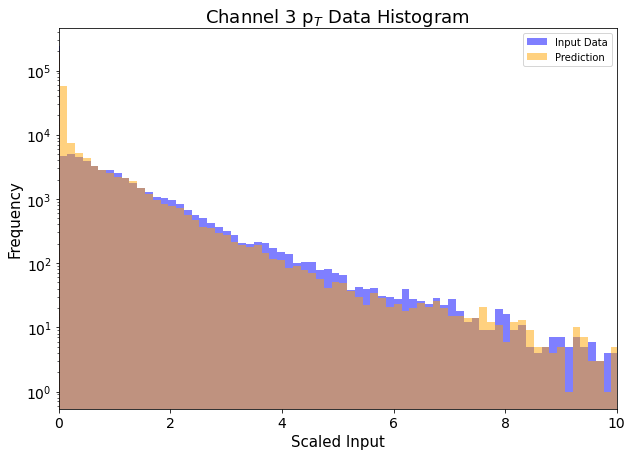

In [62]:
plt.figure(figsize=(10,7))
plt.xlim(0, 10)
plt.xlabel('Scaled Input', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Channel 3 p$_T$ Data Histogram', fontsize = 18)
plt.hist(x_test_pt.flatten(), bins = bins, color='blue', log=True, label='Input Data', alpha=0.5)
plt.hist(y_pred_pt.flatten(), bins = bins, color='orange', log=True, label='Prediction', alpha=0.5)
plt.legend()
plt.show()

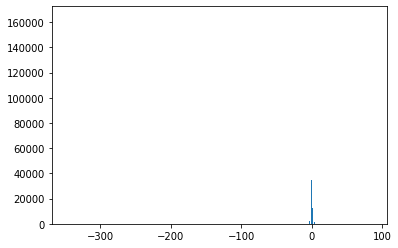

In [63]:
n, bins, patches = plt.hist(x_test_phi.flatten(), 1000)

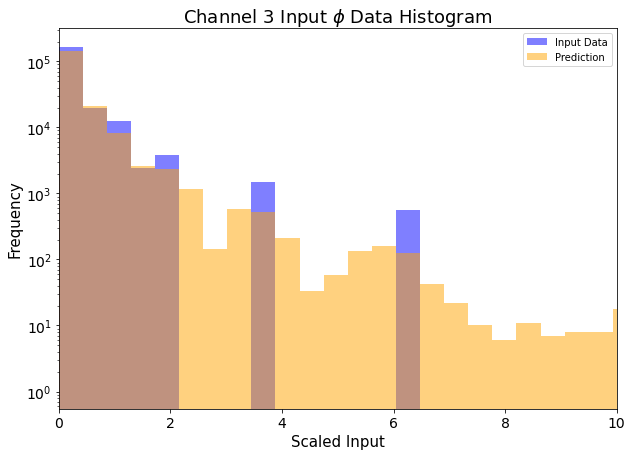

In [64]:
plt.figure(figsize=(10,7))
plt.xlim(0, 10)
plt.xlabel('Scaled Input', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Channel 3 Input $\phi$ Data Histogram', fontsize = 18)
plt.hist(x_test_phi.flatten(), bins = bins, color='blue', log=True, label='Input Data', alpha=0.5)
plt.hist(y_pred_phi.flatten(), bins = bins, color='orange', log=True, label='Prediction', alpha=0.5)
plt.legend()
plt.show()

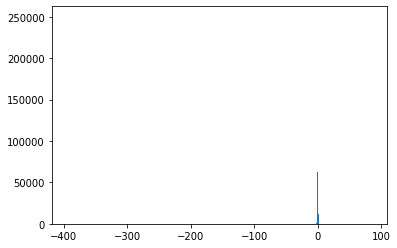

In [65]:
n, bins, patches = plt.hist(x_test_eta.flatten(), 1000)

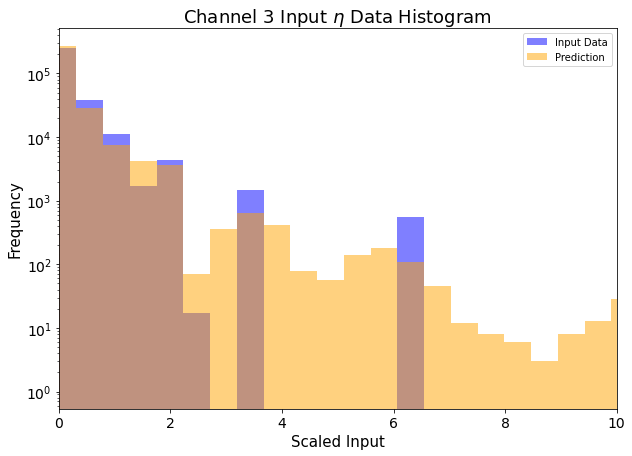

In [66]:
plt.figure(figsize=(10,7))
plt.xlim(0, 10)
plt.xlabel('Scaled Input', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Channel 3 Input $\eta$ Data Histogram', fontsize = 18)
plt.hist(x_test_eta.flatten(), bins = bins, color='blue', log=True, label='Input Data', alpha=0.5)
plt.hist(y_pred_eta.flatten(), bins = bins, color='orange', log=True, label='Prediction', alpha=0.5)
plt.legend()
plt.show()

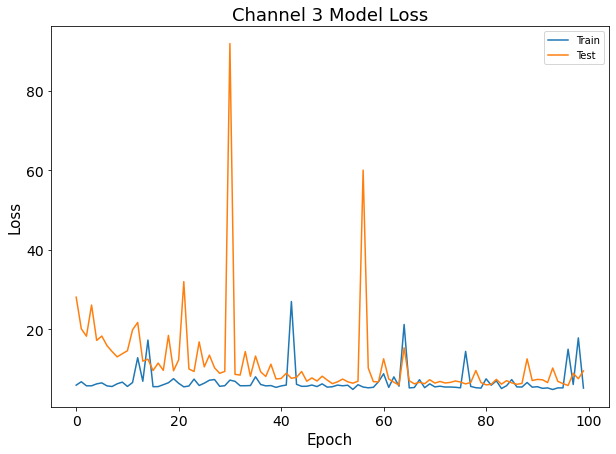

In [67]:
loss = [x for x in history_train.history['loss'] if x<100]
val_loss = [x for x in history_val.history['loss'] if x<100]
plt.figure(figsize = (10,7))
plt.plot(loss)
plt.plot(val_loss)
plt.title('Channel 3 Model Loss', fontsize = 18)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(['Train', 'Test'])#, loc='upper left')
plt.show()

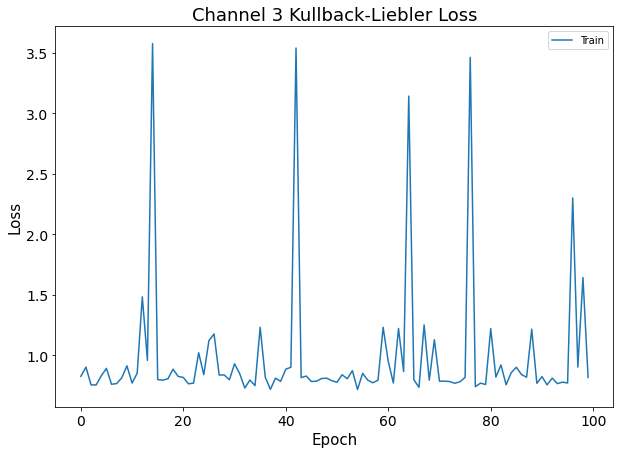

In [68]:
kl_loss = [x for x in history_train.history['kl_loss'] if x<10]
plt.figure(figsize = (10, 7))
plt.plot(kl_loss)
plt.title('Channel 3 Kullback-Liebler Loss', fontsize = 18)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(['Train', 'Test'])#, loc = 'upper left')
plt.show()

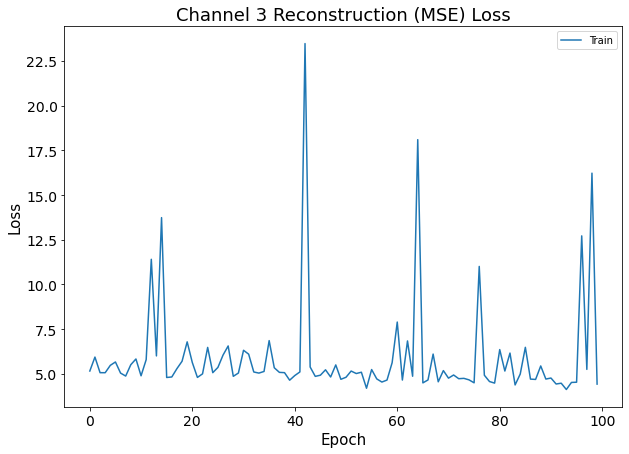

In [69]:
recon_loss = [x for x in history_train.history['reconstruction_loss'] if x<100]
plt.figure(figsize = (10, 7))
plt.plot(recon_loss)
plt.title('Channel 3 Reconstruction (MSE) Loss', fontsize = 18)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(['Train', 'Test'])#, loc = 'upper left')
plt.show()

fpr1, tpr1 = fpr_tpr_calc(path1, vae, x_test, df_bkg)
fpr2, tpr2 = fpr_tpr_calc(path2, vae, x_test, df_bkg)
fpr3, tpr3 = fpr_tpr_calc(path3, vae, x_test, df_bkg)
fpr4, tpr4 = fpr_tpr_calc(path4, vae, x_test, df_bkg)
fpr5, tpr5 = fpr_tpr_calc(path5, vae, x_test, df_bkg)
fpr6, tpr6 = fpr_tpr_calc(path6, vae, x_test, df_bkg)
fpr7, tpr7 = fpr_tpr_calc(path7, vae, x_test, df_bkg)

In [70]:
fprs = []
tprs = []
for path in paths:
    df = single_csv_to_df(path)
    if (len(df)-5)%2 != 0:
        num = str(int(((len(df.columns) - 5)/5) + 1))
        df['obj'+num]= -999
        df['E'+num] = -999
        df['pt'+num] = -999
        df['eta'+num] = -999
        df['phi'+num] = -999

    if (len(df.columns)< len(df_bkg.columns)):
        diff = int(((len(df_bkg.columns)-5)/5))-int(((len(df.columns)-5)/5))
        num = int(((len(df.columns) - 5)/5) + 1)
        for i in range(diff):
            df['obj'+str(num)]= -999
            df['E'+str(num)] = -999
            df['pt'+str(num)] = -999
            df['eta'+str(num)] = -999
            df['phi'+str(num)] = -999
            num+=1
    df = df.fillna(-999)
    variables = [entry for entry in df.columns if entry[0] == 'E'] + [entry for entry in df.columns if entry[0:2] == 'pt'] + [entry for entry in df.columns if entry[0:2] == 'et'] + [entry for entry in df.columns if entry[0:2] == 'ph']

    df = df[['process_ID']+variables]
    one_hot = pd.get_dummies(df['process_ID'])
    processes = one_hot.columns
    df.drop('process_ID', axis = 'columns', inplace = True)
    df = pd.concat([df, one_hot], sort = False, axis = 1)


    x = df[variables].values
    x_scaled = StandardScaler().fit_transform(x)
    df[variables] = x_scaled

    _, x_test_bsm, _, y_test_bsm = train_test_split(df[variables].values,
                                                    df[processes].values, 
                                                    shuffle = True,
                                                    random_state = 42,
                                                    test_size = 0.1)

    #x_train = x_train.reshape((x_train.shape[0], 1, -1, 4))
    x_test_bsm = x_test_bsm.reshape((x_test_bsm.shape[0], 1, -1, 4))
    _, _, z_bsm = encoder.predict(x_test_bsm.reshape(x_test_bsm.shape[0], 1, -1, 4))
    y_bsm = decoder.predict(z_bsm)
    _, _, z = encoder.predict(x_test.reshape(x_test.shape[0], 1, -1, 4))
    y_sm = decoder.predict(z)
    y_total = np.append(y_sm, y_bsm)
    y_sm = y_sm.flatten()
    y_bsm = y_bsm.flatten()
    
    
    y_true = np.append(np.zeros(len(y_sm)), np.ones(len(y_bsm)))
    y_total_norm = y_total/np.linalg.norm(y_total)
    
    fpr, tpr, _ = roc_curve(y_true, y_total_norm)
    fprs.append(fpr)
    tprs.append(tpr)

fpr1, tpr1 = fpr_tpr_calc(path1, vae, x_test, df_bkg)
fpr2, tpr2 = fpr_tpr_calc(path2, vae, x_test, df_bkg)
fpr3, tpr3 = fpr_tpr_calc(path3, vae, x_test, df_bkg)
fpr4, tpr4 = fpr_tpr_calc(path4, vae, x_test, df_bkg)
fpr5, tpr5 = fpr_tpr_calc(path5, vae, x_test, df_bkg)
fpr6, tpr6 = fpr_tpr_calc(path6, vae, x_test, df_bkg)
fpr7, tpr7 = fpr_tpr_calc(path7, vae, x_test, df_bkg)
fpr8, tpr8 = fpr_tpr_calc(path8, vae, x_test, df_bkg)
fpr9, tpr9 = fpr_tpr_calc(path9, vae, x_test, df_bkg)
fpr10, tpr10 = fpr_tpr_calc(path10, vae, x_test, df_bkg)

In [71]:
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'cyan', 'goldenrod', 'lavender']
#fprs = [fpr1, fpr2, fpr3, fpr4, fpr5, fpr6, fpr7, fpr8, fpr9, fpr10]
#tprs = [tpr1, tpr2, tpr3, tpr4, tpr5, tpr6, tpr7, tpr8, tpr9, tpr10]
signals = ['glgl1400_neutralino1100', 
           'glgl1600_neutralino800', 
           'gluino_1000.0_neutralino_1.0', 
           'monoV_Zp2000.0_DM_1.0', 
           'monojet_Zp2000.0_DM_50.0', 
           'monotop_200_A', 
           'sqsq1_sq1400_neut800', 
           'sqsq_sq1800_neut800', 
           'stlp_st1000', 
           'stop2b1000_neutralino300']

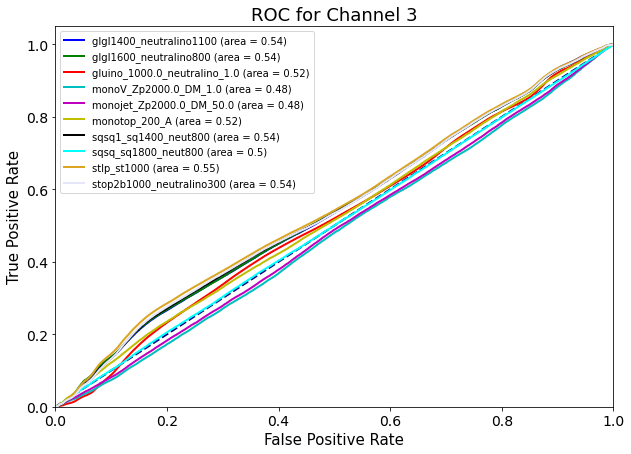

In [72]:
lw = 2
plt.figure(figsize = (10, 7))
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0., 1.])
plt.ylim([0, 1.05])
plt.title('ROC for Channel 3', fontsize = 18)
for fpr, tpr, sig, col in zip(fprs, tprs, signals, colours):
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color = col, lw = lw, 
             label = '{} (area = {})'.format(sig, round(roc_auc, 2)))
plt.legend()
plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [73]:
from performance import *

In [74]:
y_pred = y_pred.flatten()

In [75]:
AUC = []
epsilon1 = []
epsilon2 = []
epsilon3 = []

In [76]:
for i in paths:
    df_sig = single_csv_to_df(path1)
    if ((len(df_sig.columns)-5) % 2 != 0):
        num = str(int(((len(df_sig.columns) - 5)/5) + 1))
        df_sig['obj'+num]= -999
        df_sig['E'+num] = -999
        df_sig['pt'+num] = -999
        df_sig['eta'+num] = -999
        df_sig['phi'+num] = -999
        
    if (len(df_sig.columns)< len(df_bkg.columns)):
        diff = int(((len(df_bkg.columns)-5)/5))-int(((len(df_sig.columns)-5)/5))
        num = int(((len(df_sig.columns) - 5)/5) + 1)
        for i in range(diff):
            df_sig['obj'+str(num)]= -999
            df_sig['E'+str(num)] = -999
            df_sig['pt'+str(num)] = -999
            df_sig['eta'+str(num)] = -999
            df_sig['phi'+str(num)] = -999
            num+=1
    
    df = df_sig.fillna(-999)
    variables = [entry for entry in df.columns if entry[0] == 'E'] + [entry for entry in df.columns if entry[0:2] == 'pt'] + [entry for entry in df.columns if entry[0:2] == 'et'] + [entry for entry in df.columns if entry[0:2] == 'ph']

    #Now we one_hot encode the data to make sure we have a class definition
    df = df[['process_ID']+variables]
    one_hot = pd.get_dummies(df['process_ID'])
    processes = one_hot.columns
    df.drop('process_ID', axis = 'columns', inplace = True)
    df = pd.concat([df, one_hot], sort = False, axis = 1)

    x = df[variables].values
    x_scaled = StandardScaler().fit_transform(x)
    df[variables] = x_scaled

    x_train, x_test, y_train, y_test = train_test_split(df[variables].values,
                                                        df[processes].values, 
                                                        shuffle = True,
                                                        random_state = 42,
                                                        test_size = 0.1)
    x_test = x_test.reshape((x_test.shape[0], 1, -1, 4))

    y_pred_sig = vae.predict(x_test)
    y_pred_sig = y_pred_sig.flatten()

    auc, ep1, ep2, ep3 = performance(y_pred, y_pred_sig)

    AUC.append(auc)
    epsilon1.append(ep1)
    epsilon2.append(ep2)
    epsilon3.append(ep3)

NotImplementedError: in user code:

    /home/joe/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /home/joe/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/joe/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/joe/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/joe/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/joe/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /home/joe/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /home/joe/anaconda3/lib/python3.7/site-packages/keras/engine/base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/joe/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:446 call  **
        raise NotImplementedError('When subclassing the `Model` class, you should '

    NotImplementedError: When subclassing the `Model` class, you should implement a `call` method.


In [ ]:
AUC

In [ ]:
epsilon1

In [ ]:
epsilon2

In [ ]:
epsilon3